In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [158]:
df_preprocessed = pd.read_excel("df_preprocessed.xlsx")     #47.651

In [159]:
df_preprocessed.columns

Index(['Unnamed: 0', 'YearMonth', 'Product_ID', 'Units_sold', 'Product_Line',
       'Product_Category', 'Year', 'Month', 'Unique_Customers', 'Units_CM',
       'Units_LM', 'Customers_LM', 'Rolling_mean_4m', 'trend_4m',
       'trend_4m_pct', 'MoM_Growth_pct', 'Is_First_Month',
       'MoM_Growth_pct_Cust', 'Trend_4M', 'Trend_4M_C', 'vs_trend_abs',
       'vs_trend_pct_Prod', 'vs_trend_pct_Cust', 'Rolling_std_4m',
       'Volatility', 'Consec_Drop_Prod', 'Consec_Drop_Cust',
       'Target_ConsecCustDrop', 'Units_per_Cust', 'Trend_Units_per_Cust',
       'Target_UnitsPerCust_Drop', 'NegTrend', 'Trend_Negative_Streak',
       'P75_Units', 'CM_vs_P75', 'Target_UnderTrend_Cust', 'Target_Volatility',
       'Target_UnderTrend', 'Target_ConsecDrop', 'Target_NegTrend',
       'Target_vs_P75', 'Target_Next_Month_Risk_Label',
       'Target_UnderTrend_shifted', 'Target_UnderTrend_Cust_shifted',
       'Target_Volatility_shifted', 'Target_ConsecDrop_shifted',
       'Target_vs_P75_shifted', 'Tar

y1 - CONSEQ DROP

In [160]:
df_model_y1 = df_preprocessed[['Product_ID','vs_trend_pct_Prod', 'MoM_Growth_pct', 'Volatility', 'Consec_Drop_Prod', 'vs_trend_pct_Cust', 'Trend_Negative_Streak', 'Year', 'Month', 'Target_ConsecDrop_shifted']]

In [161]:
#define X
id_cols = ['Product_ID', 'Year', 'Month']  
features = ['vs_trend_pct_Prod', 'MoM_Growth_pct', 'Volatility', 'Consec_Drop_Prod', 'vs_trend_pct_Cust', 'Trend_Negative_Streak']  
X_full = df_model_y1[id_cols + features].copy()

# Keep X for training, but preserve IDs
X = X_full[features]
X_id = X_full[id_cols]

In [162]:
#create a test dataset that will be used for each of the target modeling
#X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

#split: shared across all models
X_train, X_test, id_train, id_test = train_test_split(X, X_id, test_size=0.2, random_state=42)

In [163]:
#1 target modeling: CONSECUTIVE DROP
#define y
y = df_model_y1['Target_ConsecDrop_shifted']
#check data imbalance
print(y.value_counts(normalize=True)) #2.3% true

#get y_train and y_test by matching X indices
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

#Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Set up hyperparameter tuning
param_grid = {'n_estimators': [100],'learning_rate': [0.1],'max_depth': [3, 5]}

model_conseq_drop = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, scoring= 'f1', cv=3,           #number of cross-validation folds — the data is split into 3 parts for training/validation
    verbose=1, n_jobs=-1)

model_conseq_drop.fit(X_train_res, y_train_res)

best_model = model_conseq_drop.best_estimator_

#predict probs on original test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred = (y_prob >=threshold).astype(int)

print(classification_report(y_test, y_pred))

Target_ConsecDrop_shifted
0    0.972299
1    0.027701
Name: proportion, dtype: float64
Fitting 3 folds for each of 2 candidates, totalling 6 fits
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      9294
           1       0.11      0.90      0.19       237

    accuracy                           0.81      9531
   macro avg       0.55      0.85      0.54      9531
weighted avg       0.97      0.81      0.87      9531



In [164]:
test_results_y1 = id_test.copy()   # start with the IDs 
test_results_y1['Target_ConsecDrop_shifted'] = y_test.values
test_results_y1['Pred_ConsecDrop_Pct'] = y_prob * 100
test_results_y1['Pred_ConsecDrop_Label'] = y_pred
test_results_y1.to_excel("pred_y1.xlsx", index=False)

In [165]:
#2 target modeling: Target_UnderTrend
y = df_preprocessed['Target_UnderTrend_shifted']
#Align y with existing X_train/X_test
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

param_grid = {'n_estimators': [100],'learning_rate': [0.1], 'max_depth': [3, 5]}

model_under_trend = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

model_under_trend.fit(X_train_res, y_train_res)
best_model = model_under_trend.best_estimator_

y_prob = best_model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred = (y_prob >= threshold).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79      8648
           1       0.20      0.83      0.33       883

    accuracy                           0.69      9531
   macro avg       0.59      0.75      0.56      9531
weighted avg       0.90      0.69      0.75      9531



In [166]:
#append predictions to X_test
test_results_y2 = id_test.copy()
test_results_y2['Target_UnderTrend_shifted'] = y_test.values
test_results_y2['Pred_UnderTrend_Pct'] = y_prob * 100
test_results_y2['Pred_UnderTrend_Label'] = y_pred

test_results_y2.to_excel("pred_y2.xlsx", index=False)

In [167]:
#3 target modeling: Target_CustUnderTrend
y = df_preprocessed['Target_UnderTrend_Cust_shifted']

y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

param_grid = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]} 

model_cust_under_trend = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

model_cust_under_trend.fit(X_train_res, y_train_res)
best_model = model_cust_under_trend.best_estimator_

y_prob = best_model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred = (y_prob >= threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.66      0.79      9302
           1       0.05      0.69      0.09       229

    accuracy                           0.66      9531
   macro avg       0.52      0.67      0.44      9531
weighted avg       0.97      0.66      0.77      9531



In [168]:
test_results_y3 = id_test.copy()
test_results_y3['Target_UnderTrend_Cust_shifted'] = y_test.values
test_results_y3['Pred_UnderTrend_Cust_Pct'] = y_prob * 100
test_results_y3['Pred_UnderTrend_Cust_Label'] = y_pred

test_results_y3.to_excel("pred_y3.xlsx", index=False)

y4 - NegTrend

In [169]:
# Target 4 modeling: Target_NegTrend_shifted 
y = df_preprocessed['Target_NegTrend_shifted']

y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

param_grid = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]}

model_neg_trend = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

model_neg_trend.fit(X_train_res, y_train_res)
best_model = model_neg_trend.best_estimator_

y_prob = best_model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred = (y_prob >= threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92      8542
           1       0.45      0.98      0.61       989

    accuracy                           0.87      9531
   macro avg       0.72      0.92      0.77      9531
weighted avg       0.94      0.87      0.89      9531



In [170]:
test_results_y4 = id_test.copy()
test_results_y4['Target_NegTrend_shifted'] = y_test.values
test_results_y4['Pred_NegTrend_Pct'] = y_prob * 100
test_results_y4['Pred_NegTrend_Label'] = y_pred

test_results_y4.to_excel("pred_y4.xlsx", index=False)

y5 - VOLATILITY

In [171]:
# Target 5 modeling: Target_Volatility_shifted 
y = df_preprocessed['Target_Volatility_shifted']

y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

param_grid = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]}

model_volatility = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

model_volatility.fit(X_train_res, y_train_res)
best_model = model_volatility.best_estimator_

y_prob = best_model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred = (y_prob >= threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85      5222
           1       0.79      0.89      0.84      4309

    accuracy                           0.84      9531
   macro avg       0.84      0.85      0.84      9531
weighted avg       0.85      0.84      0.84      9531



In [172]:
test_results_y5 = id_test.copy()
test_results_y5['Target_Volatility_shifted'] = y_test.values
test_results_y5['Pred_Volatility_Pct'] = y_prob * 100
test_results_y5['Pred_Volatility_Label'] = y_pred

test_results_y5.to_excel("pred_y5.xlsx", index=False)

In [173]:
#combine preds
df1 = test_results_y1
df2 = test_results_y2
df3 = test_results_y3
df4 = test_results_y4
df5 = test_results_y5

# Merge them on Product_ID (+ Year, Month if needed. keeping join keys clean))
df_combined = df1.merge(df2, on=['Product_ID', 'Year', 'Month']) \
                 .merge(df3, on=['Product_ID', 'Year', 'Month']) \
                 .merge(df4, on=['Product_ID', 'Year', 'Month']) \
                 .merge(df5, on=['Product_ID', 'Year', 'Month'])

In [174]:
""" #Export combined result
df_combined.to_excel("combined_predictions_test.xlsx", index=False)
df_combined #9531 """

' #Export combined result\ndf_combined.to_excel("combined_predictions_test.xlsx", index=False)\ndf_combined #9531 '

In [175]:
# avg risk score test data
""" df_combined['Avg_Risk_Score'] = df_combined[[ 'Pred_ConsecDrop_Pct_norm', 'Pred_UnderTrend_Pct_norm', 'Pred_CustUnderTrend_Pct_norm', 'Pred_Volatility_Pct_norm']].mean(axis=1)
df_combined['Risk_Label'] = (df_combined['Avg_Risk_Score'] > 0.7).astype(int)
overall_avg_risk = df_combined['Avg_Risk_Score'].mean()
print(f"Overall avg risk score: {overall_avg_risk:.4f}")
#df_combined #9.237 
# df_combined['Risk_Label'].value_counts(normalize=True)  #1: 0.02164 """

' df_combined[\'Avg_Risk_Score\'] = df_combined[[ \'Pred_ConsecDrop_Pct_norm\', \'Pred_UnderTrend_Pct_norm\', \'Pred_CustUnderTrend_Pct_norm\', \'Pred_Volatility_Pct_norm\']].mean(axis=1)\ndf_combined[\'Risk_Label\'] = (df_combined[\'Avg_Risk_Score\'] > 0.7).astype(int)\noverall_avg_risk = df_combined[\'Avg_Risk_Score\'].mean()\nprint(f"Overall avg risk score: {overall_avg_risk:.4f}")\n#df_combined #9.237 \n# df_combined[\'Risk_Label\'].value_counts(normalize=True)  #1: 0.02164 '

In [176]:
df_preprocessed['Pred_ConsecDrop'] = model_conseq_drop.predict_proba(X)[:, 1]
df_preprocessed['Pred_UnderTrend'] = model_under_trend.predict_proba(X)[:, 1]
df_preprocessed['Pred_UnderTrend_Cust'] = model_cust_under_trend.predict_proba(X)[:, 1]
df_preprocessed['Pred_NegTrend'] = model_neg_trend.predict_proba(X)[:, 1]
df_preprocessed['Pred_Volatility'] = model_volatility.predict_proba(X)[:, 1] #47.651
df_preprocessed

,Unnamed: 0,YearMonth,Product_ID,Units_sold,Product_Line,Product_Category,Year,Month,Unique_Customers,Units_CM,...,Target_Volatility_shifted,Target_ConsecDrop_shifted,Target_vs_P75_shifted,Target_NegTrend_shifted,Target_Next_Month_Risk_shifted,Pred_ConsecDrop,Pred_UnderTrend,Pred_UnderTrend_Cust,Pred_NegTrend,Pred_Volatility
0,1249,2022-02-01,Product_1,10890,Product_Line_A,Product_Category_AA,2022,2,69,1.132671,...,0,0,0,0,0,0.003567,0.175082,0.134923,0.001403,0.115429
1,2499,2022-03-01,Product_1,8820,Product_Line_A,Product_Category_AA,2022,3,69,0.758542,...,0,0,0,0,0,0.633829,0.191600,0.155808,0.001307,0.297394
2,3752,2022-04-01,Product_1,10650,Product_Line_A,Product_Category_AA,2022,4,69,1.074050,...,0,0,0,0,0,0.004692,0.260056,0.202420,0.002793,0.099030
3,4999,2022-05-01,Product_1,10080,Product_Line_A,Product_Category_AA,2022,5,75,1.039511,...,0,0,0,0,0,0.021106,0.290912,0.266381,0.002166,0.075016
4,6245,2022-06-01,Product_1,11190,Product_Line_A,Product_Category_AA,2022,6,81,0.982072,...,0,1,0,0,0,0.848043,0.226849,0.358362,0.001963,0.057859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47646,44411,2024-12-01,Product_999,510,Product_Line_A,Product_Category_AB,2024,12,6,1.470495,...,1,0,0,0,0,0.003302,0.669395,0.558429,0.810282,0.963923
47647,45590,2025-01-01,Product_999,630,Product_Line_A,Product_Category_AB,2025,1,6,1.146655,...,1,0,0,0,1,0.047431,0.728160,0.606809,0.001395,0.767531
47648,46783,2025-02-01,Product_999,240,Product_Line_A,Product_Category_AB,2025,2,6,0.451386,...,1,0,0,0,0,0.742067,0.153176,0.431740,0.001005,0.971168
47649,47965,2025-03-01,Product_999,750,Product_Line_A,Product_Category_AB,2025,3,7,1.292657,...,1,0,0,0,0,0.004415,0.666008,0.349817,0.796465,0.967526


META MODEL

In [177]:
features = [
    'Consec_Drop_Prod',
    'vs_trend_pct_Prod',
    'vs_trend_pct_Cust',
    'Volatility',
    'NegTrend']

X_meta = df_preprocessed[features]
y_meta = df_preprocessed['Target_Next_Month_Risk_shifted']


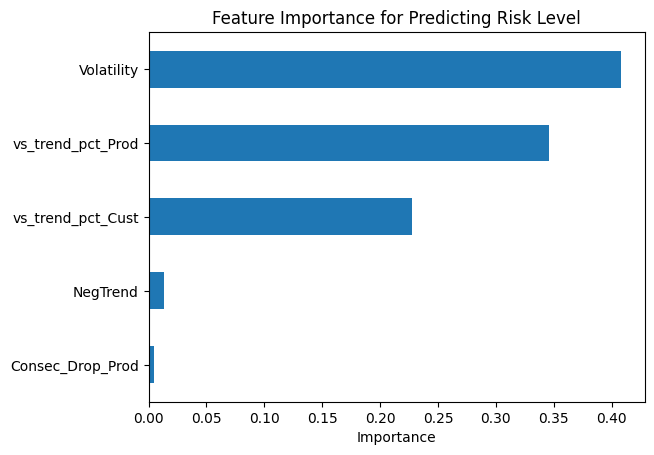

In [178]:
#FEATURE IMPORTANCE
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)

importances.plot(kind='barh')
plt.title("Feature Importance for Predicting Risk Level")
plt.xlabel("Importance")
plt.show()

In [179]:
#check data imbalance
print(y_meta.value_counts(normalize=True)) #1 = 14.9%, 2 = 0.029%

Target_Next_Month_Risk_shifted
0    0.847894
1    0.149231
2    0.002875
Name: proportion, dtype: float64


In [180]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

meta_model = XGBClassifier(max_depth=3)
meta_model.fit(X_train_res, y_train_res)

y_pred = meta_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.75      8047
           1       0.32      0.62      0.43      1460
           2       0.01      0.29      0.01        24

    accuracy                           0.63      9531
   macro avg       0.42      0.51      0.40      9531
weighted avg       0.84      0.63      0.70      9531



In [181]:
X

,vs_trend_pct_Prod,MoM_Growth_pct,Volatility,Consec_Drop_Prod,vs_trend_pct_Cust,Trend_Negative_Streak
0,0.000000,0.188431,0.000000,0,0.000000,0
1,0.000000,-0.330307,0.000000,0,0.000000,0
2,0.098320,0.415940,0.168692,0,0.014706,1
3,0.032698,-0.032157,0.166077,0,0.024590,0
4,-0.072600,-0.055256,0.147202,0,0.015038,0
...,...,...,...,...,...,...
47646,1.089262,1.803083,0.777760,0,0.153846,2
47647,-0.105378,-0.220225,0.415554,0,-0.032258,0
47648,-0.447347,-0.606345,0.548570,0,-0.062500,1
47649,0.426804,1.863749,0.409109,0,0.044776,2


In [182]:
df = df_preprocessed

In [183]:
#NORMALIZATION risk factors
risk_factors = ['Pred_ConsecDrop', 'Pred_UnderTrend', 'Pred_UnderTrend_Cust', 'Pred_Volatility', 'Pred_NegTrend']
scaler = MinMaxScaler()
df[[f"{col}_norm" for col in risk_factors]] = scaler.fit_transform(df[risk_factors])
df

,Unnamed: 0,YearMonth,Product_ID,Units_sold,Product_Line,Product_Category,Year,Month,Unique_Customers,Units_CM,...,Pred_ConsecDrop,Pred_UnderTrend,Pred_UnderTrend_Cust,Pred_NegTrend,Pred_Volatility,Pred_ConsecDrop_norm,Pred_UnderTrend_norm,Pred_UnderTrend_Cust_norm,Pred_Volatility_norm,Pred_NegTrend_norm
0,1249,2022-02-01,Product_1,10890,Product_Line_A,Product_Category_AA,2022,2,69,1.132671,...,0.003567,0.175082,0.134923,0.001403,0.115429,0.003324,0.175876,0.133333,0.100350,0.001207
1,2499,2022-03-01,Product_1,8820,Product_Line_A,Product_Category_AA,2022,3,69,0.758542,...,0.633829,0.191600,0.155808,0.001307,0.297394,0.652605,0.193146,0.154844,0.288633,0.001109
2,3752,2022-04-01,Product_1,10650,Product_Line_A,Product_Category_AA,2022,4,69,1.074050,...,0.004692,0.260056,0.202420,0.002793,0.099030,0.004483,0.264713,0.202853,0.083381,0.002622
3,4999,2022-05-01,Product_1,10080,Product_Line_A,Product_Category_AA,2022,5,75,1.039511,...,0.021106,0.290912,0.266381,0.002166,0.075016,0.021393,0.296973,0.268732,0.058534,0.001984
4,6245,2022-06-01,Product_1,11190,Product_Line_A,Product_Category_AA,2022,6,81,0.982072,...,0.848043,0.226849,0.358362,0.001963,0.057859,0.873283,0.229997,0.363470,0.040781,0.001777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47646,44411,2024-12-01,Product_999,510,Product_Line_A,Product_Category_AB,2024,12,6,1.470495,...,0.003302,0.669395,0.558429,0.810282,0.963923,0.003052,0.692660,0.569535,0.978305,0.824394
47647,45590,2025-01-01,Product_999,630,Product_Line_A,Product_Category_AB,2025,1,6,1.146655,...,0.047431,0.728160,0.606809,0.001395,0.767531,0.048513,0.754097,0.619364,0.775093,0.001199
47648,46783,2025-02-01,Product_999,240,Product_Line_A,Product_Category_AB,2025,2,6,0.451386,...,0.742067,0.153176,0.431740,0.001005,0.971168,0.764109,0.152975,0.439048,0.985801,0.000802
47649,47965,2025-03-01,Product_999,750,Product_Line_A,Product_Category_AB,2025,3,7,1.292657,...,0.004415,0.666008,0.349817,0.796465,0.967526,0.004197,0.689120,0.354669,0.982033,0.810333


Next_Month_Risk_Rule_Based

In [184]:
df['Avg_Risk_Score'] = df[[ 'Pred_ConsecDrop_norm', 'Pred_UnderTrend_norm', 'Pred_UnderTrend_Cust_norm', 'Pred_NegTrend_norm', 'Pred_Volatility_norm']].mean(axis=1)
df['Risk_Rule_Based'] = (df['Avg_Risk_Score'] > 0.6).astype(int)
overall_avg_risk = df['Avg_Risk_Score'].mean()    #46.184, 29,2%
print(f"Overall avg risk score: {overall_avg_risk:.4f}")    

Overall avg risk score: 0.2993


In [185]:
df.columns

Index(['Unnamed: 0', 'YearMonth', 'Product_ID', 'Units_sold', 'Product_Line',
       'Product_Category', 'Year', 'Month', 'Unique_Customers', 'Units_CM',
       'Units_LM', 'Customers_LM', 'Rolling_mean_4m', 'trend_4m',
       'trend_4m_pct', 'MoM_Growth_pct', 'Is_First_Month',
       'MoM_Growth_pct_Cust', 'Trend_4M', 'Trend_4M_C', 'vs_trend_abs',
       'vs_trend_pct_Prod', 'vs_trend_pct_Cust', 'Rolling_std_4m',
       'Volatility', 'Consec_Drop_Prod', 'Consec_Drop_Cust',
       'Target_ConsecCustDrop', 'Units_per_Cust', 'Trend_Units_per_Cust',
       'Target_UnitsPerCust_Drop', 'NegTrend', 'Trend_Negative_Streak',
       'P75_Units', 'CM_vs_P75', 'Target_UnderTrend_Cust', 'Target_Volatility',
       'Target_UnderTrend', 'Target_ConsecDrop', 'Target_NegTrend',
       'Target_vs_P75', 'Target_Next_Month_Risk_Label',
       'Target_UnderTrend_shifted', 'Target_UnderTrend_Cust_shifted',
       'Target_Volatility_shifted', 'Target_ConsecDrop_shifted',
       'Target_vs_P75_shifted', 'Tar

In [186]:
meta_features = [
    'Consec_Drop_Prod',
    'vs_trend_pct_Prod',
    'vs_trend_pct_Cust',
    'Volatility',
    'NegTrend']
X_meta = df[meta_features]
y_meta = df['Target_Next_Month_Risk_shifted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, stratify=y_meta, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

meta_model = XGBClassifier(max_depth=3)
meta_model.fit(X_train_res, y_train_res)

# Evaluate on test set
y_pred = meta_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      8081
           1       0.30      0.61      0.41      1422
           2       0.01      0.39      0.02        28

    accuracy                           0.62      9531
   macro avg       0.41      0.54      0.39      9531
weighted avg       0.83      0.62      0.69      9531



In [187]:
# Predict on the full dataset, including April 2025
df['Next_Month_Risk_ML'] = meta_model.predict(X_meta) #47.651

In [188]:
(X.index == df.index).all() #check if index matches

np.True_

In [189]:
first_months = pd.read_excel("dropped_first_months.xlsx")

In [190]:
df_model_final = pd.concat([df, first_months], axis=0).sort_index()   #49.129     df_dropped_last_months

In [191]:
df_model_final.fillna(0, inplace=True)
df_model_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49129 entries, 0 to 47650
Data columns (total 62 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      49129 non-null  int64         
 1   YearMonth                       49129 non-null  datetime64[ns]
 2   Product_ID                      49129 non-null  object        
 3   Units_sold                      49129 non-null  int64         
 4   Product_Line                    49129 non-null  object        
 5   Product_Category                49129 non-null  object        
 6   Year                            49129 non-null  int64         
 7   Month                           49129 non-null  int64         
 8   Unique_Customers                49129 non-null  int64         
 9   Units_CM                        49129 non-null  float64       
 10  Units_LM                        49129 non-null  float64       
 11  Custome

In [192]:
df_model_final["Next_Month_Risk_ML"].value_counts()

Next_Month_Risk_ML
0.0    27894
1.0    14655
2.0     6580
Name: count, dtype: int64

In [193]:
def adjust_risk(row):
    if row['Next_Month_Risk_ML'] == 2 and row['Avg_Risk_Score'] > 0.6:
        return 2
    elif row['Next_Month_Risk_ML'] == 1 and row['Avg_Risk_Score'] > 0.4:
        return 1
    else:
        return 0

df_model_final['Next_Month_Risk_ML_Adjusted'] = df_model_final.apply(adjust_risk, axis=1)

In [200]:
#Weighted Risk Score
df_model_final['Weighted_Risk_Score'] = (df_model_final['Pred_ConsecDrop_norm'] * 0.1 + 
                                         df_model_final['Pred_UnderTrend_norm'] * 0.2 + 
                                         df_model_final['Pred_UnderTrend_Cust_norm'] * 0.2 + 
                                         df_model_final['Pred_NegTrend_norm'] * 0.15 +
                                         df_model_final['Pred_Volatility_norm'] * 0.35)
df_model_final['Weighted_Risk_Rule_Based'] = (df_model_final['Weighted_Risk_Score'] > 0.6).astype(int)
overall_weighted_risk = df_model_final['Weighted_Risk_Rule_Based'].mean()    #46.184, 29,2%
print(f"Overall weighted risk score: {overall_weighted_risk:.4f}")    

Overall weighted risk score: 0.1275


In [207]:
#Next_Month_Risk_ML_Adjusted_Weighted 
def adjust_risk_weighted(row):
    if row['Next_Month_Risk_ML'] == 2 and row['Weighted_Risk_Score'] > 0.65:
        return 2
    elif row['Next_Month_Risk_ML'] == 1 and row['Weighted_Risk_Score'] > 0.4:
        return 1
    else:
        return 0

df_model_final['Next_Month_Risk_ML_Adjusted_Weighted'] = df_model_final.apply(adjust_risk_weighted, axis=1)

In [208]:
df_model_final.to_excel("df_PBI.xlsx")

In [204]:
df_model_final.columns

Index(['Unnamed: 0', 'YearMonth', 'Product_ID', 'Units_sold', 'Product_Line',
       'Product_Category', 'Year', 'Month', 'Unique_Customers', 'Units_CM',
       'Units_LM', 'Customers_LM', 'Rolling_mean_4m', 'trend_4m',
       'trend_4m_pct', 'MoM_Growth_pct', 'Is_First_Month',
       'MoM_Growth_pct_Cust', 'Trend_4M', 'Trend_4M_C', 'vs_trend_abs',
       'vs_trend_pct_Prod', 'vs_trend_pct_Cust', 'Rolling_std_4m',
       'Volatility', 'Consec_Drop_Prod', 'Consec_Drop_Cust',
       'Target_ConsecCustDrop', 'Units_per_Cust', 'Trend_Units_per_Cust',
       'Target_UnitsPerCust_Drop', 'NegTrend', 'Trend_Negative_Streak',
       'P75_Units', 'CM_vs_P75', 'Target_UnderTrend_Cust', 'Target_Volatility',
       'Target_UnderTrend', 'Target_ConsecDrop', 'Target_NegTrend',
       'Target_vs_P75', 'Target_Next_Month_Risk_Label',
       'Target_UnderTrend_shifted', 'Target_UnderTrend_Cust_shifted',
       'Target_Volatility_shifted', 'Target_ConsecDrop_shifted',
       'Target_vs_P75_shifted', 'Tar

In [196]:
df[(df['Month'] == 4) & (df['Year'] == 2025)]['Next_Month_Risk_ML'].value_counts(dropna=False)


Next_Month_Risk_ML
0    616
1    389
2    155
Name: count, dtype: int64